In [1]:
%load_ext autoreload
%autoreload 2

from sklearn.model_selection import ShuffleSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.cross_decomposition import PLSRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor


from nirs4all.operators.transformations import Gaussian, SavitzkyGolay, StandardNormalVariate, Haar, MultiplicativeScatterCorrection
from nirs4all.operators.models.cirad_tf import nicon, customizable_nicon
from nirs4all.pipeline.config import PipelineConfigs
from nirs4all.dataset.dataset_config import DatasetConfigs
from nirs4all.pipeline.runner import PipelineRunner
import json
from sklearn.ensemble import GradientBoostingRegressor

pipeline = [
    MinMaxScaler(feature_range=(0.1, 0.8)),
    MultiplicativeScatterCorrection,
    ShuffleSplit(n_splits=3),
    {"y_processing": MinMaxScaler},
    {"model": PLSRegression(15)},
    {"model": PLSRegression(10)},
    {"model": RandomForestRegressor(n_estimators=100)},
    {"model": ElasticNet()},
    {"model": SVR(kernel='rbf', C=1.0, epsilon=0.1)},
    {"model": MLPRegressor(hidden_layer_sizes=(50,50), max_iter=500)},
    {"model": GradientBoostingRegressor(n_estimators=100)},
    {"model": nicon,
     "train_params": {
                # Final training parameters
                "epochs": 500,
                "patience": 50,
                "batch_size": 500,
                # "cyclic_lr": True,
                # "step_size": 20,
                "lr": 0.001,
                "verbose": 0  # 0=silent, 1=progress bar, 2=one line per epoch
            },
    },

]

# create pipeline config
config = PipelineConfigs(pipeline)

# path = ['../../sample_data/regression', '../../sample_data/classification', '../../sample_data/binary']
path = '../../sample_data/regression'
dataset_config_obj = DatasetConfigs(path)

# Runner setup with spinner enabled (default is True, but let's be explicit)
runner = PipelineRunner(save_files=False, show_spinner=True, verbose=2)
print("🔄 Running pipeline with spinner enabled - watch for loading animations during model training!")
predictions, results = runner.run(config, dataset_config_obj)

🔄 Running pipeline with spinner enabled - watch for loading animations during model training!
🚀 Starting pipeline run with 1 pipeline configuration(s) on 1 dataset configuration(s) (1 total runs).
✅ Loaded dataset 'regression' with 130 training and 59 test samples.
📊 Dataset: regression
Features (samples=189, sources=1):
- Source 0: (189, 1, 2151), processings=['raw'], min=-0.265, max=1.436, mean=0.466, var=0.149)
Targets: (samples=189, targets=1, processings=['numeric'])
- numeric: min=1.33, max=128.31, mean=30.779
Indexes:
- "train", ['raw']: 130 samples
- "test", ['raw']: 59 samples
📥 Loaded 162 predictions from results\regression\regression_predictions.json
🚀 Starting pipeline config_bc79abf3 on dataset regression
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
🔷 Step 1: {'class': 'sklearn.preprocessing._data.MinMaxScaler', 'params

✅ nicon_73 - test: mse=0.0254↓ (mae: 0.1366)
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
🏆 Best for config: PLSRegression_10_10 - mse=81.4408↓
✅ Pipeline config_bc79abf3 completed successfully on dataset regression
--------------------------------------------------------------------------------------------------------------------------------------------
🏆 Best from this run: fold (bc79abf3_PLSRegression_10) - mse=81.4408↓


1. PLSRegression_10 - config_bc79abf3 - RMSE: 9.024453, R²: 0.531533, MAE: 7.234554, MSE: 81.440757
2. PLSRegression_16 - config_bc79abf3 - RMSE: 11.098860, R²: 0.352655, MAE: 10.067900, MSE: 123.184704
3. MLPRegressor_52 - config_bc79abf3 - RMSE: 11.896611, R²: 0.256253, MAE: 9.832137, MSE: 141.529358
4. ElasticNet_37 - config_bc79abf3 - RMSE: 14.087773, R²: -0.141622, MAE: 12.572912, MSE: 198.465363
5. PLSRegression_7 - config_bc79abf3 - RMSE: 14.214646, R²: -0.061820, MAE: 11.285312, MSE: 202.056166


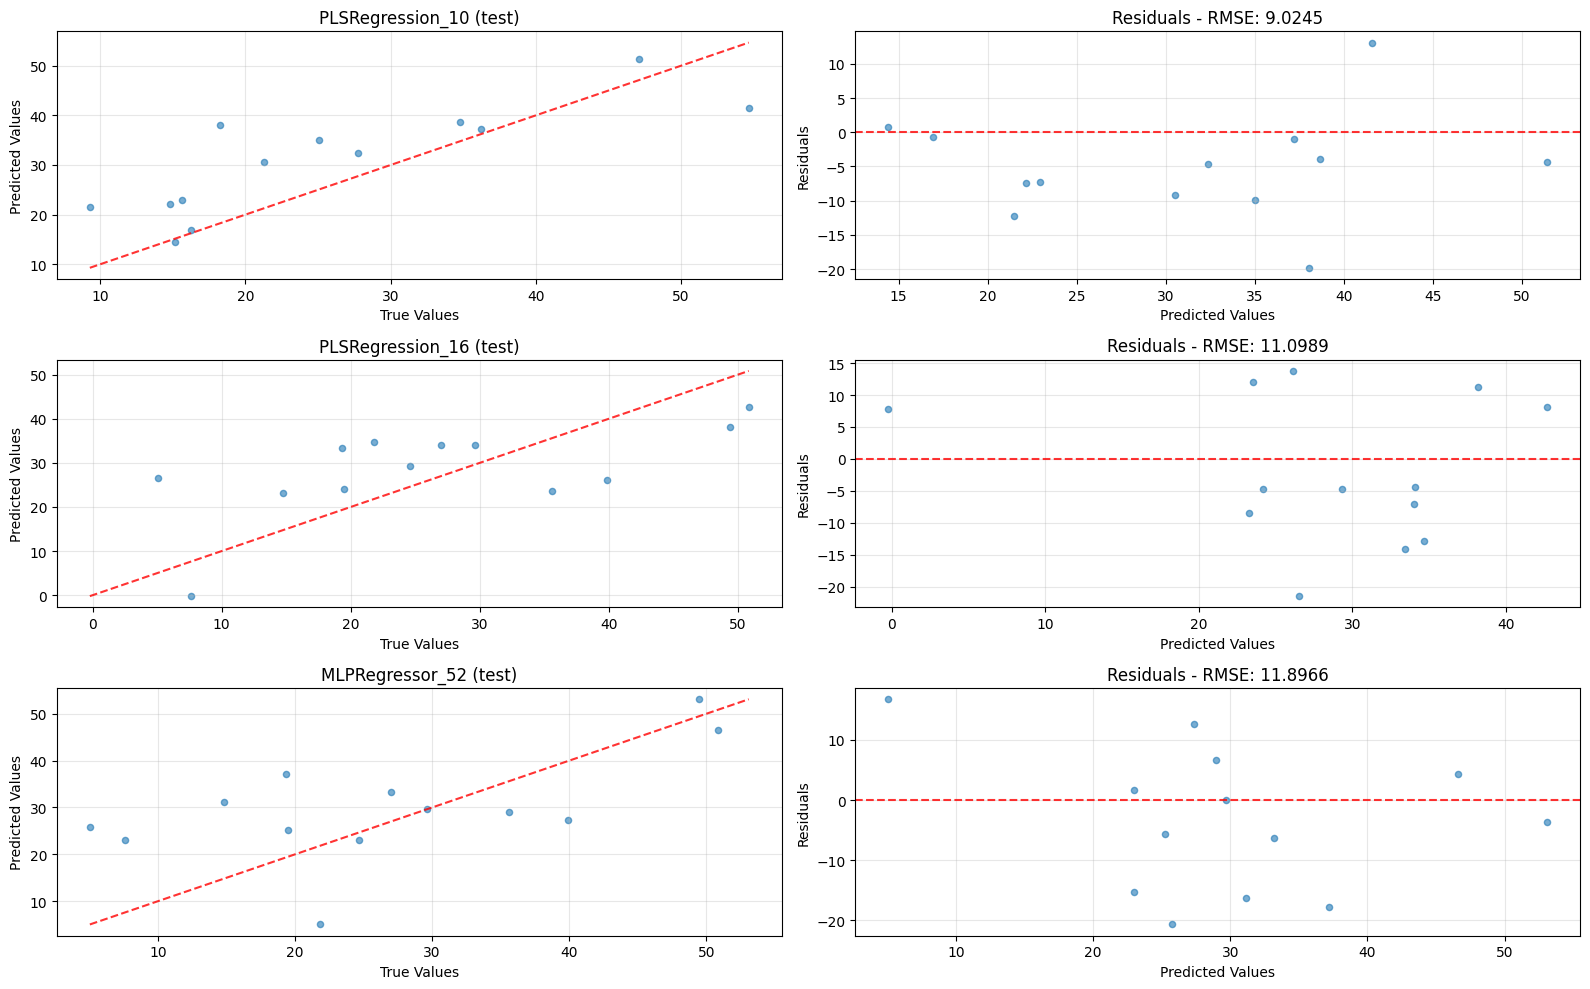

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from nirs4all.dataset.prediction_analyzer import PredictionAnalyzer

analyzer = PredictionAnalyzer(predictions)

top_5 = analyzer.get_top_k(5, 'mse')
for i, model in enumerate(top_5, 1):
    # Use enhanced_model_name which includes custom names when available
    enhanced_name = model.get('enhanced_model_name', model.get('real_model', 'unknown'))
    pipeline_path = model.get('path', '')

    # Extract config ID from pipeline path or key
    config_id = "unknown"
    if 'config_' in pipeline_path:
        config_part = pipeline_path.split('config_')[1].split('/')[0] if '/' in pipeline_path else pipeline_path.split('config_')[1]
        config_id = f"config_{config_part}"

    print(f"{i}. {enhanced_name} - {config_id} - RMSE: {model['metrics']['rmse']:.6f}, R²: {model['metrics']['r2']:.6f}, MAE: {model['metrics']['mae']:.6f}, MSE: {model['metrics']['mse']:.6f}")

# Plot top_k comparison with enhanced names in titles
fig = analyzer.plot_top_k_comparison(k=3, metric='rmse', partition_type='test')
plt.show()